# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.090512,False,-1.067480
1,-2.359753,False,-1.391967
2,-1.113612,False,-1.833544
3,-0.213552,True,5.109589
4,0.161978,True,5.295897
...,...,...,...
995,0.099020,False,-0.406061
996,0.729739,True,6.516901
997,-0.469214,False,-0.960461
998,-1.554427,False,0.007999


<Axes: xlabel='v0'>

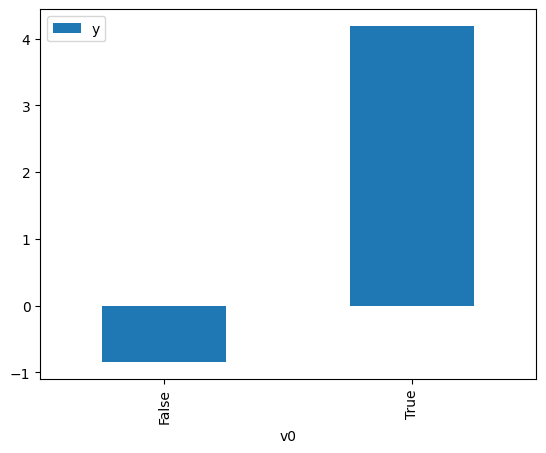

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

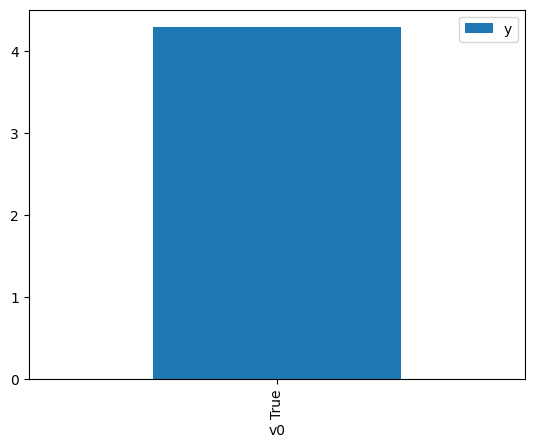

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.191180,False,-1.537256,0.969043,1.031946
1,-0.981642,False,-0.835002,0.818323,1.222012
2,0.856927,False,0.535554,0.191256,5.228592
3,-2.730193,False,-4.239011,0.986714,1.013465
4,-1.547382,False,-0.898235,0.917723,1.089653
...,...,...,...,...,...
995,-1.530290,False,-2.684343,0.915631,1.092143
996,-0.912892,False,-0.317634,0.801363,1.247875
997,1.201569,False,1.794796,0.119806,8.346815
998,-3.546461,False,-3.131815,0.996374,1.003639


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.441209,True,5.575899,0.345515,2.894227
1,0.202394,True,5.092432,0.596949,1.675184
2,-0.503640,True,6.603457,0.323250,3.093579
3,-2.363473,True,1.869387,0.023664,42.258344
4,-0.722973,True,3.687679,0.251538,3.975546
...,...,...,...,...,...
995,-2.363473,True,1.869387,0.023664,42.258344
996,-0.836584,True,4.419168,0.218825,4.569856
997,1.478116,True,5.582937,0.919644,1.087377
998,1.899662,True,7.670540,0.957433,1.044459


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                              4440.
Date:                Thu, 24 Jul 2025   Prob (F-statistic):                        0.00
Time:                        08:02:15   Log-Likelihood:                         -1447.5
No. Observations:                1000   AIC:                                      2899.
Df Residuals:                     998   BIC:                                      2909.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1583      0.026     45.081      0.000       1.108       1.209
x2             4.9857      0.060     83.549      0.000       4.869       5.103
==============================================================================
Omnibus:                        3.556   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                4.061
Skew:                           0.000   Prob(JB):                        0.131
Kurtosis:                       3.312   Cond. No.                         2.32
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""